# Full Model Fine-Tuning

This notebook enables you to fine-tune pretrained language models (PLMs) on your own datasets.

To improve efficiency and performance, we employed Parameter-Efficient Fine-Tuning (PEFT) using LoRA (Low-Rank Adaptation of Large Language Models) as described in the other colab file.


Note: In this example, we use the relatively small ESM2 8M model to achieve faster training on a single T4 GPU in Google Colab. Larger models or longer sequence lengths will require more GPU memory and significantly longer training times.

# Install Packages

In [6]:
!pip install datasets
!pip install evaluate
!pip install SentencePiece
!pip install transformers[torch]
!pip install peft
!pip install Biopython
!pip install mpi4py

In [10]:
import torch
import numpy as np
import pandas as pd
import transformers
import datasets as datasets

print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.8.0+cu126
Cuda version:  12.6
Numpy version:  2.0.2
Pandas version:  2.2.2
Transformers version:  4.57.1
Datasets version:  4.0.0


In [11]:
import torch, numpy as np, random

seed = 21
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load training data

In [15]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_layer_training.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df.head())
print("\nTotal sequences:", len(df))


     name                                           sequence  label
0  Q9H161  MNAETCVSYCESPAAAMDAYYSPVSQSREGSSPFRAFPGGDKFGTT...      1
1  Q9HBZ2  MATPAAVNPPEMASDIPGSVTLPVAPMAATGQVRMAGAMPARGGKR...      1
2  E9PKN1  MADQRMDISSTISDFMSPGPTDLLSSSLGTSGVDCNRKRKGSSTDY...      1
3  P50553  MESSAKMESGGAGQQPQPQPQQPFLPPAACFFATAAAAAAAAAAAA...      1
4  P15336  MKFKLHVNSARQYKDLWNMSDDKPFLCTAPGCGQRFTNEDHLAVHK...      1

Total sequences: 832


In [16]:
from datasets import Dataset
# Convert label column to int (already done)
df['label'] = df['label'].astype(int)

# Optional: Map label to class names if needed
label2id = {label: i for i, label in enumerate(sorted(df['label'].unique()))}
id2label = {i: label for label, i in label2id.items()}

# Convert dataframe to HuggingFace dataset
dataset = Dataset.from_pandas(df)

In [17]:
type(dataset)

datasets.arrow_dataset.Dataset

# Custom Head Classifier

In [18]:
import torch.nn as nn
import torch.nn.functional as F


class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        # x shape: (batch_size, seq_len, embedding_size)
        if attention_mask is not None:
            # masked mean pooling
            mask = attention_mask.unsqueeze(-1)  # (batch_size, seq_len, 1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)  # mean pooling over sequence
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [19]:
#Load tokenzier and model

from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = "facebook/esm2_t6_8M_UR50D"  # or other ESM-2 variant

tokenizer = AutoTokenizer.from_pretrained(model_name)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=2,
    problem_type="single_label_classification"
)

embedding_size = model.config.hidden_size
model.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)
model = model.to("cuda:0")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/95.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/93.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/31.4M [00:00<?, ?B/s]

Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Freeze classification head
# for param in model.classifier.parameters():
#     param.requires_grad = False

In [ ]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name)

In [20]:
# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())

print(f"Trainable parameters: {trainable_params:,}")
print(f"Total parameters: {all_params:,}")

Trainable parameters: 7,450,427
Total parameters: 7,450,427


In [21]:
def tokenize_function(example):
    return tokenizer(example["sequence"], truncation=True, padding="max_length", max_length=1024)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.2)

Map:   0%|          | 0/832 [00:00<?, ? examples/s]

In [22]:
# ds_config = {
#   "train_batch_size": "auto",
#   "gradient_accumulation_steps": "auto",
#   "fp16": {
#     "enabled": True
#   },
#   "zero_optimization": {
#     "stage": 2,
#     "offload_optimizer": {
#       "device": "cpu",
#       "pin_memory": True
#     },
#     "overlap_comm": True
#   },
#   "gradient_clipping": 1.0
# }

In [23]:
trainable = [name for name, param in model.named_parameters() if param.requires_grad]
frozen = [name for name, param in model.named_parameters() if not param.requires_grad]

print(f"Trainable layers: {len(trainable)}")
print(trainable[:5])  # print a few

print("\n")

print(f"Frozen layers: {len(frozen)}")
print(frozen[:5])  # print a few



from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./ESM2-8M-with-Finetune",
    logging_dir="./logs",
    learning_rate=1e-5,
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    gradient_accumulation_steps=8, #Effective gradient_accumulation is 8
    num_train_epochs=10,
    eval_steps=500,
    logging_steps=100,
    logging_strategy="epoch",
    eval_strategy="epoch",
    save_strategy="epoch",
    warmup_ratio=0.05,
    max_grad_norm=1.0,
    fp16=True,
    #deepspeed= ds_config,
    report_to="none"
)

Trainable layers: 105
['esm.embeddings.word_embeddings.weight', 'esm.encoder.layer.0.attention.self.query.weight', 'esm.encoder.layer.0.attention.self.query.bias', 'esm.encoder.layer.0.attention.self.key.weight', 'esm.encoder.layer.0.attention.self.key.bias']


Frozen layers: 0
[]


In [24]:
from sklearn.metrics import accuracy_score

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

In [25]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    compute_metrics=compute_metrics,
)

In [26]:
import os
os.environ["WANDB_DISABLED"] = "true"

trainer.train()

The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2}.


Epoch,Training Loss,Validation Loss,Accuracy
1,0.676400,0.647056,0.586826
2,0.571600,0.495186,0.880240
3,0.417700,0.375811,0.886228
4,0.332300,0.343948,0.886228
5,0.295500,0.336501,0.886228
6,0.264700,0.328564,0.880240
7,0.250400,0.335129,0.880240
8,0.243400,0.331899,0.880240
9,0.233600,0.334904,0.874251
10,0.231100,0.335845,0.868263


TrainOutput(global_step=840, training_loss=0.3516733714512416, metrics={'train_runtime': 271.7915, 'train_samples_per_second': 24.467, 'train_steps_per_second': 3.091, 'total_flos': 303975109939200.0, 'train_loss': 0.3516733714512416, 'epoch': 10.0})

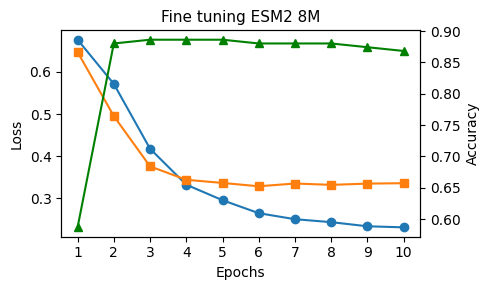

In [29]:
import matplotlib.pyplot as plt

train_loss, eval_loss, eval_accuracy, epochs = [], [], [], []

for entry in trainer.state.log_history:
    if "loss" in entry and "epoch" in entry:
        train_loss.append(entry["loss"])
    if "eval_loss" in entry:
        eval_loss.append(entry["eval_loss"])
    if "eval_accuracy" in entry:
        eval_accuracy.append(entry["eval_accuracy"])
    if "epoch" in entry:
        epochs.append(entry["epoch"])

# Make sure x-axis aligns
x = list(range(1, len(train_loss)+1))

fig, ax1 = plt.subplots(figsize=(5, 3))

# Plot loss curves on the left y-axis
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.plot(x, train_loss,   marker='o')
ax1.plot(x, eval_loss,   marker='s')
ax1.set_xticks(x)
ax1.tick_params(axis='y')

# Instantiate a second axes sharing the same x-axis for accuracy
ax2 = ax1.twinx()
ax2.set_ylabel('Accuracy')
ax2.plot(x, eval_accuracy, color='green', marker='^')
ax2.tick_params(axis='y')

# Combine legends
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
#ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center')
#ax2.set_ylim(0.8, 0.95)
plt.title('Fine tuning ESM2 8M', fontsize=11)
#plt.grid(True)
plt.tight_layout()
#plt.savefig('../Figures/With_FineTuning/Fine_tuning_ESM2_8M_without_LoRA.png', dpi=400)  # Save the figure
plt.show()

In [32]:
# Directory to save
# Save model, tokenzier, and Custom Head Classifier separately
# The standard save_pretrained method from Transformers won’t automatically save the custom head class code.
# We need to save both the model weights and the custom head properly.

save_dir = "Saved_Models/fine_tuned_ESM2_8M_model_with_custom_head"

# Save Hugging Face model weights (excluding custom head)
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

# Save custom head weights separately
torch.save(model.classifier.state_dict(), f"{save_dir}/custom_head.pt")

## Load the saved model

In [31]:
#Load the Saved Model

import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

import torch.nn as nn
import torch.nn.functional as F

class CustomHeadClassifier(nn.Module):
    def __init__(self, embedding_size, hidden_size, dropout, num_classes):
        super(CustomHeadClassifier, self).__init__()
        self.fc1 = nn.Linear(embedding_size, hidden_size)
        self.dropout = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x, attention_mask=None):
        if attention_mask is not None:
            mask = attention_mask.unsqueeze(-1)
            x = (x * mask).sum(1) / mask.sum(1)
        else:
            x = x.mean(dim=1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [33]:
save_dir = "Saved_Models/fine_tuned_ESM2_8M_model_with_custom_head"
tokenizer = AutoTokenizer.from_pretrained(save_dir)
model_load = AutoModelForSequenceClassification.from_pretrained(save_dir, num_labels=2)
embedding_size = model_load.config.hidden_size
model_load.classifier = CustomHeadClassifier(embedding_size, hidden_size=128, dropout=0.3, num_classes=2)

# Load the trained weights
model_load.classifier.load_state_dict(torch.load(f"{save_dir}/custom_head.pt"))

# Move to GPU if needed
model_load = model_load.to("cuda:0")
model_load.eval()  # set to evaluation mode

Some weights of the model checkpoint at Saved_Models/fine_tuned_ESM2_8M_model_with_custom_head were not used when initializing EsmForSequenceClassification: ['classifier.fc1.bias', 'classifier.fc1.weight', 'classifier.fc2.bias', 'classifier.fc2.weight']
- This IS expected if you are initializing EsmForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing EsmForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of EsmForSequenceClassification were not initialized from the model checkpoint at Saved_Models/fine_tuned_ESM2_8M_model_with_custom_head and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias

EsmForSequenceClassification(
  (esm): EsmModel(
    (embeddings): EsmEmbeddings(
      (word_embeddings): Embedding(33, 320, padding_idx=1)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): EsmEncoder(
      (layer): ModuleList(
        (0-5): 6 x EsmLayer(
          (attention): EsmAttention(
            (self): EsmSelfAttention(
              (query): Linear(in_features=320, out_features=320, bias=True)
              (key): Linear(in_features=320, out_features=320, bias=True)
              (value): Linear(in_features=320, out_features=320, bias=True)
              (rotary_embeddings): RotaryEmbedding()
            )
            (output): EsmSelfOutput(
              (dense): Linear(in_features=320, out_features=320, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (LayerNorm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
          )
          (intermediate): EsmIntermediate(
            (dense): Linear(in_features

In [34]:
# Check if CUDA is available
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Load independent dataset

In [38]:
import pandas as pd
from Bio import SeqIO
import requests
from io import StringIO

# GitHub raw link
url = 'https://raw.githubusercontent.com/MirTanveer/Fine-Tune-TF/main/Data/First_Layer_Independent.txt'

# Fetch the data from GitHub
response = requests.get(url)
response.raise_for_status()  # ensure the download worked

# Parse the FASTA data from the text
sequences = []
for record in SeqIO.parse(StringIO(response.text), "fasta"):
    # Example header format: >seq1%someinfo%LABEL=1
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extract numeric label
    sequences.append([record.name, str(record.seq), label])

# Create a DataFrame
df_test= pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display
print(df_test.head())
print("\nTotal sequences:", len(df_test))


     name                                           sequence  label
0  A6NJG6  MRNRMAPENPQPDPFINRNYSNMKVIPPQDPASPSFTLLSKLECSG...      1
1  Q96QS3  MSNQYQEEGCSERPECKSKSPTLLSSYCIDSILGRRSPCKMRLLGA...      1
2  Q8N100  MKSCKPSGPPAGARVAPPCAGGTECAGTCAGAGRLESAARRRLAAN...      1
3  Q9NY43  MTMEGASGSSFGIDTILSSASSGSPGMMNGDFRPLGEARTADFRSQ...      1
4  Q96T88  MWIQVRTMDGRQTHTVDSLSRLTKVEELRRKIQELFHVEPGLQRLF...      1

Total sequences: 212


In [39]:
from datasets import Dataset

df_test["label"] = df_test["label"].astype(int)
test_dataset = Dataset.from_pandas(df_test)

In [40]:
def tokenize_function(example):
    return tokenizer(example["sequence"], padding="max_length", truncation=True, max_length=1024)

test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/212 [00:00<?, ? examples/s]

In [ ]:
# Create Trainer again for evaluation
# trainer_loaded = Trainer(model=model, tokenizer=tokenizer)
# predictions = trainer_loaded.predict(test_dataset)

In [41]:
from transformers import Trainer

trainer = Trainer(model=model_load, tokenizer=tokenizer)

predictions = trainer.predict(test_dataset)

/tmp/ipython-input-1707723771.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model_load, tokenizer=tokenizer)
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [42]:
import numpy as np
import torch.nn.functional as F
logits = predictions.predictions
labels = predictions.label_ids
preds = np.argmax(logits, axis=-1)
probs = F.softmax(torch.tensor(logits), dim=-1).numpy()  # shape: [N, num_classes]

In [43]:
from sklearn.metrics import accuracy_score, classification_report

acc = accuracy_score(labels, preds)
print(f"Test Accuracy: {acc:.4f}")

# Optional: detailed report
print(classification_report(labels, preds))

Test Accuracy: 0.9009
              precision    recall  f1-score   support

           0       0.90      0.91      0.90       106
           1       0.90      0.90      0.90       106

    accuracy                           0.90       212
   macro avg       0.90      0.90      0.90       212
weighted avg       0.90      0.90      0.90       212



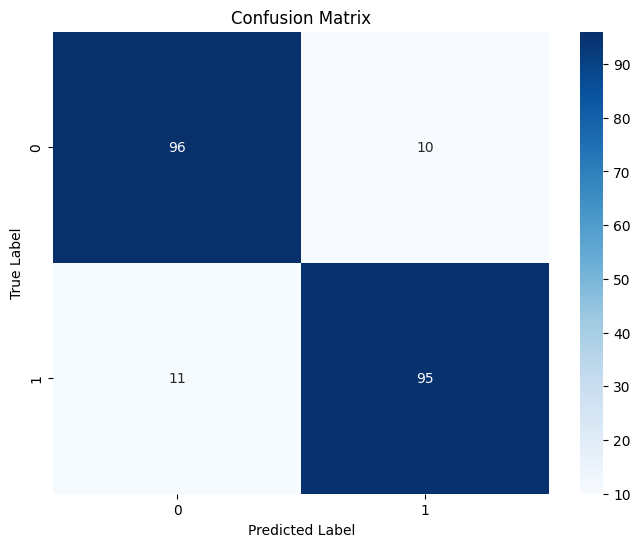

In [44]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
cm = confusion_matrix(labels, preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [45]:
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve
auc = roc_auc_score(labels, probs[:, 1])
print(f"AUC Score (Binary): {auc:.4f}")

AUC Score (Binary): 0.9402


In [46]:
TN, FP, FN, TP = cm.ravel()

In [47]:
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
specificity= TN / (TN + FP) if (TN + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0  # Recall = Sensitivity
# Matthews correlation coefficient
import numpy as np
numerator = (TP * TN) - (FP * FN)
denominator = np.sqrt((TP + FP)*(TP + FN)*(TN + FP)*(TN + FN))
mcc = numerator / denominator if denominator > 0 else 0
F1_score= (2*precision*recall)/(precision+recall)

In [48]:
print("Precision value is: ", precision)
print("Specificity value is: ", specificity)
print("Recall value is: ", recall)
print("Mcc score is: ", mcc)
print("F1 Score is: ", F1_score)

Precision value is:  0.9047619047619048
Specificity value is:  0.9056603773584906
Recall value is:  0.8962264150943396
Mcc score is:  0.8019224786544211
F1 Score is:  0.9004739336492891
